In [1]:
from pathlib import Path
import os

# Detectar automáticamente si estamos en portátil o sobremesa
possible_roots = [
    Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak"),  # sobremesa
    Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak")  # portátil
]

for path in possible_roots:
    if path.exists():
        project_root = path
        break
else:
    raise FileNotFoundError("⚠️ Ninguna ruta válida encontrada para project_root.")

# Establecer como directorio de trabajo
os.chdir(project_root)
print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [2]:
# ----------------------------------------------
# 🎯 FUTPEAK — Etapa 1: Carga y revisión inicial de los datos
# ----------------------------------------------

# 📌 Objetivo de esta celda:
# - Cargar los datasets base: logs de partidos (matchlogs) y metadatos de jugadores (metadata)
# - Hacer una revisión general de columnas, tipos, nulos y duplicados
# - Validar que ambas tablas están listas para ser combinadas y utilizadas en el modelado
# ----------------------------------------------

import pandas as pd
from pathlib import Path

# 📁 Ruta base donde están los datos procesados (ajustada a la estructura del proyecto)
data_path = Path("data/processed")

# 🧾 Archivos CSV de interés
matchlogs_path = data_path / "cleaned_matchlogs.csv"
metadata_path = data_path / "cleaned_metadata.csv"

# ----------------------------------------------
# 📥 Función de carga segura con información básica
# ----------------------------------------------
def load_csv(path, name):
    """
    Carga un CSV desde la ruta dada y muestra su tamaño.
    Si hay error, devuelve un DataFrame vacío.
    """
    try:
        df = pd.read_csv(path)
        print(f"✅ {name} cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {name}: {e}")
        return pd.DataFrame()

# 🔄 Cargar ambos datasets
matchlogs = load_csv(matchlogs_path, "matchlogs")
metadata = load_csv(metadata_path, "metadata")

# ----------------------------------------------
# 👀 Vista preliminar: estructura general
# ----------------------------------------------
def preview_df(df, name):
    print(f"\n📄 {name.upper()} — columnas:")
    print(df.columns.tolist())
    print(df.head(2))

preview_df(matchlogs, "matchlogs")
preview_df(metadata, "metadata")

# ----------------------------------------------
# 🧼 Revisión de duplicados y valores nulos
# ----------------------------------------------

# Duplicados en la clave primaria del metadata
print("\n🔍 Duplicados en Player_ID (metadata):", metadata["Player_ID"].duplicated().sum())

# Nulos por columna en cada dataset
print("\n🧼 Nulos en matchlogs:")
print(matchlogs.isnull().sum().sort_values(ascending=False))

print("\n🧼 Nulos en metadata:")
print(metadata.isnull().sum().sort_values(ascending=False))

# ----------------------------------------------
# ✅ Resultado esperado de esta etapa:
# - Confirmar que los archivos se cargan bien
# - Entender la estructura de las tablas y los tipos de datos
# - Saber si podemos unir ambas por Player_ID sin problemas
# - Identificar qué columnas deberemos imputar o limpiar
# ----------------------------------------------


✅ matchlogs cargado correctamente: 688871 filas, 46 columnas.
✅ metadata cargado correctamente: 12489 filas, 13 columnas.

📄 MATCHLOGS — columnas:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']
        Player_name Player_ID Seasons        Date  Day  Competition  \
0  Luciano Abecasis  6c510f2d    2016  2016-02-05  Fri  Primera Div   
1  Luciano Abecasis  6c510f2d    2016  2016-0

In [3]:
# Conocer número total de jugadores 
total_unique_players = matchlogs['Player_ID'].nunique()
print("Total number of unique players:", total_unique_players)


Total number of unique players: 5210


In [4]:
import re

# ----------------------------------------------
# 🎯 Objetivo:
# Filtrar jugadores ofensivos (delanteros, extremos, mediapuntas)
# según la columna 'Position' del metadata.
# ----------------------------------------------

# 📌 Lista de abreviaciones ofensivas comunes en bases de datos
offensive_labels = ['CF', 'ST', 'FW', 'LW', 'RW', 'WF', 'IF', 'F']

# 🧵 Creamos un patrón de regex que busque esas etiquetas como palabra completa
# ya sea al inicio (^), al final ($), o entre guiones (ej: 'LW-RW' o 'CAM-ST')
pattern = r'(^|[-])(?:' + '|'.join(offensive_labels) + r')($|[-])'

# 🧪 Aplicamos el filtro sobre la columna 'Position' ignorando nulos
mask_attack = metadata['Position'].str.contains(pattern, na=False)

# 📊 Número de jugadores ofensivos detectados
print(f"🎯 Jugadores ofensivos encontrados: {mask_attack.sum()}")

# 🔍 Visualizamos los jugadores ofensivos
offensive_players = metadata[mask_attack]
display(offensive_players)



🎯 Jugadores ofensivos encontrados: 3675


C:\Users\juanm\AppData\Local\Temp\ipykernel_39224\4182563840.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_attack = metadata['Position'].str.contains(pattern, na=False)


,Player_ID,Player_name,Full_name,Url_template,Birth_date,Age,Position,Footed,Birth_place,Nationality,Club,First_name,Gender
1,db5ee72d,Ramon Abila,Ramón Darío Ábila,https://fbref.com/en/players/db5ee72d/Ramon-Abila,1989-10-14,35-198,FW,Right,"Córdoba, Argentina",Argentina,Huracán,Ramon,male
6,363ba6d7,Luciano Acosta,Luciano Federico Acosta,https://fbref.com/en/players/363ba6d7/Luciano-...,1994-05-31,30-334,AM-FC-FW-MF,Right,"Rosario, Argentina",Argentina,FC Dallas,Luciano,male
8,15741f49,Walter Acuna,NaN,https://fbref.com/en/players/15741f49/Walter-A...,1992-03-04,NaN,FW,NaN,NaN,Argentina,NaN,Walter,male
14,d9ebfcfa,Gabriel Alanis,NaN,https://fbref.com/en/players/d9ebfcfa/Gabriel-...,1994-03-16,31-045,AM-DF-FW-MF-WM,Left,"Córdoba, Argentina",Argentina,Huracán,Gabriel,male
16,834d0be5,Lucas Alario,Lucas Nicolás Alario,https://fbref.com/en/players/834d0be5/Lucas-Al...,1992-10-08,32-204,FW-LP,Right,"Tostado, Argentina",Argentina,Estudiantes (LP),Lucas,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12478,727e7bf1,Dior Angus,NaN,https://fbref.com/en/players/727e7bf1/Dior-Angus,NaN,NaN,FW-MF,NaN,NaN,England,NaN,Dior,unknown
12479,6f4a2915,Joe Anyinsah,Joseph Greene Anyinsah,https://fbref.com/en/players/6f4a2915/Joe-Anyi...,NaN,NaN,FW,NaN,NaN,England,NaN,Joe,male
12482,68c720b5,Adam Armstrong,Adam James Armstrong,https://fbref.com/en/players/68c720b5/Adam-Arm...,1997-02-10,28-096,AM-FW-MF,Right,"Newcastle upon Tyne, England, United Kingdom",England,West Bromwich Albion,Adam,male
12485,4966b48d,Nathan Arnold,Nathan Anthony Arnold,https://fbref.com/en/players/4966b48d/Nathan-A...,NaN,NaN,AM-FW-MF-WM,NaN,NaN,England,NaN,Nathan,male


In [5]:
# ----------------------------------------------
# 🎯 Etapa 2: Unión de datos, detección de ofensivos y cálculo de edad
# ----------------------------------------------
# Objetivos:
# - Filtrar jugadores ofensivos con un regex robusto.
# - Unir metadata y matchlogs por Player_ID.
# - Calcular edad por partido.
# - Revisar columnas con nulos que puedan requerir limpieza o imputación.
# ----------------------------------------------

import re

# 📌 Grupos posicionales útiles para análisis general (no solo atacantes)
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],
    'DEFENSIVE': ['CB', 'LB', 'RB', 'FB', 'LWB', 'RWB', 'SW', 'D'],
    'MIDFIELD': ['CM', 'DM', 'MF', 'AM'],
    'ATTACKING': ['CF', 'ST', 'F', 'FW', 'LW', 'RW', 'WF', 'IF', 'OL', 'OR']
}

# ----------------------------------------------
# 1. Filtrado de atacantes con regex + género masculino
# ----------------------------------------------
offensive_pattern = r'(^|-)(?:CF|ST|FW|LW|RW|WF|IF|F|OL|OR)($|-)'
df_attack = metadata[
    metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &
    (metadata['Gender'] == 'male')
].copy()

# 🔁 Asignamos grupo posicional para referencia (opcional)
def assign_position_group(position):
    for group, roles in POSITION_GROUPS.items():
        if any(pos in position for pos in roles):
            return group
    return 'UNKNOWN'

df_attack['Position_Group'] = df_attack['Position'].apply(assign_position_group)

print(f"\n✅ Jugadores ofensivos detectados: {df_attack['Player_ID'].nunique()}")

# ----------------------------------------------
# 2. Unir logs de partido con metadata filtrada
# ----------------------------------------------
df = matchlogs.merge(
    df_attack[['Player_ID', 'Position', 'Birth_date', 'Position_Group']],
    on='Player_ID', how='inner'  # Solo ofensivos
)

print(f"📊 Total de registros (partidos ofensivos): {df.shape[0]}")
print(f"👤 Jugadores ofensivos únicos: {df['Player_ID'].nunique()}")

# 🧼 Limpiar columnas duplicadas si las hubiera
if 'Position_x' in df.columns and 'Position_y' in df.columns:
    df['Position'] = df['Position_y']
    df.drop(columns=['Position_x', 'Position_y'], inplace=True)

# ----------------------------------------------
# 3. Cálculo de edad por partido
# ----------------------------------------------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Birth_date'] = pd.to_datetime(df['Birth_date'], errors='coerce')
df['Age'] = (df['Date'] - df['Birth_date']).dt.days / 365.25

print("\n🧾 Ejemplo de edad calculada:")
print(df[['Player_ID', 'Date', 'Birth_date', 'Age']].head())

# ----------------------------------------------
# 4. Revisión de nulos (absoluto y %)
# ----------------------------------------------
nulls = df.isnull().sum()
null_pct = (nulls / len(df)) * 100
null_info = pd.DataFrame({'Nulls': nulls, 'Percentage': null_pct})
print("\n🔎 Nulos por columna (top 10):")
print(null_info[null_info['Nulls'] > 0].sort_values(by='Percentage', ascending=False).head(10))

# ----------------------------------------------
# ✅ Resultado:
# - Matchlogs unidos a metadata ofensiva
# - Edad calculada por partido
# - Nulos listados para preparar limpieza antes del modelado
# ----------------------------------------------




✅ Jugadores ofensivos detectados: 2936
📊 Total de registros (partidos ofensivos): 200581
👤 Jugadores ofensivos únicos: 1350


C:\Users\juanm\AppData\Local\Temp\ipykernel_39224\4238351322.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &



🧾 Ejemplo de edad calculada:
  Player_ID       Date Birth_date        Age
0  db5ee72d 2024-02-11 1989-10-14  34.327173
1  db5ee72d 2024-02-11 1989-10-14  34.327173
2  db5ee72d 2024-02-14 1989-10-14  34.335387
3  db5ee72d 2024-02-14 1989-10-14  34.335387
4  db5ee72d 2024-02-24 1989-10-14  34.362765

🔎 Nulos por columna (top 10):
                        Nulls  Percentage
Penaltys_conceded      173849   86.672716
Penaltys_won           173849   86.672716
Tackles_won            139737   69.666120
Crosses                139736   69.665621
Fouls_drawn            139736   69.665621
Fouls_committed        139736   69.665621
Offsides               139735   69.665123
Percent_passes         131996   65.806831
Touches                131268   65.443886
Shot_creating_actions  131268   65.443886


In [6]:
# ----------------------------------------------
# 🎯 Etapa 2.1: Verificación de jugadores ofensivos perdidos en el merge
# ----------------------------------------------

# 1. Identificamos IDs ofensivos que no quedaron en el DataFrame final tras el merge
missing_ids = set(df_attack['Player_ID']) - set(df['Player_ID'])
print(f"🔍 Jugadores ofensivos que no entraron al merge: {len(missing_ids)}")

# 2. De esos IDs, verificamos si tienen registros en matchlogs
missing_in_logs = matchlogs[matchlogs['Player_ID'].isin(missing_ids)]
num_with_logs = missing_in_logs['Player_ID'].nunique()

print(f"📊 Jugadores con datos en matchlogs aunque no quedaron en df: {num_with_logs}")

# ----------------------------------------------
# 🔎 Posibles razones por las que un jugador ofensivo no entra al merge:
# - Tiene registros en metadata pero no jugó ningún partido (0 matchlogs).
# - Tiene matchlogs pero no fue incluido en el merge por filtrado previo (ej: género, posición).
# ----------------------------------------------



🔍 Jugadores ofensivos que no entraron al merge: 1586
📊 Jugadores con datos en matchlogs aunque no quedaron en df: 0


In [7]:
# Número total de jugadores del df
df['Player_ID'].unique()
# Número total de jugadores del df
len(df['Player_ID'].unique())



1350

In [8]:
unique_players = df[['Player_ID', 'Player_name']].drop_duplicates().sort_values('Player_name')
print(unique_players.to_string(index=False))


Player_ID                     Player_name
 14c2e443                    Aaron Nemane
 1fd66907                  Abdoul Diawara
 1757d7bb                      Abel Balbo
 8dfed6e9                    Adolfo Gaich
 86bc2c16                  Adrian Dabasse
 4ec73d8a                         Adriano
 7330f886                   Adrián Dalmau
 68b35520                Adrián Fernández
 48ad8e8f                     Adrián León
 098a28f8                  Agustin Hausch
 b5a3e7fe                Agustín Auzmendi
 9a864054                Agustín Balbuena
 a98f4de5                  Agustín Bouzat
 cc00dedf               Agustín Cacabelos
 89fd5410                  Agustín Colazo
 06424feb                  Agustín Coscia
 6abc87e1              Agustín Curruhinca
 0cb368a6                    Agustín Díaz
 deb75bd4                 Agustín Fontana
 8ac63e52                   Agustín Gallo
 e516a74d               Agustín Giaquinto
 1030ba06            Agustín Gil Clarotti
 3867759b          Agustín Gonzále

In [9]:
print("Columnas en df:", df.columns.tolist())


Columnas en df: ['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_date', 'Position_Group', 'Position', 'Age']


In [10]:
# ----------------------------------------------
# 🎯 Etapa 3: Cálculo del rating ofensivo por partido y agregación por temporada
# ----------------------------------------------
# Objetivo:
# - Calcular un rating ponderado por 90 minutos
# - Agregar por jugador y año natural (temporada)
# ----------------------------------------------

# 1. Variables clave para la fórmula
rating_vars = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df[rating_vars] = df[rating_vars].fillna(0)

# 2. Fórmula de rating (sin alterar aún, pero lista para ser ajustada)
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

df['rating_per_90'] = df.apply(calculate_rating, axis=1)

# 3. Año calendario para agrupar
df['Calendar_year'] = df['Date'].dt.year

print(f"🧾 Número de filas en df antes del groupby: {len(df)}")
print(df[['Player_ID', 'Date', 'Minutes', 'Goals']].head())

# 4. Agregamos por jugador y año calendario
df_season = df.groupby(['Player_ID', 'Calendar_year']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'Age': 'mean'
}).reset_index()

# ✅ Evitar error si df_season está vacío
if not df_season.empty:
    sample_id = df_season['Player_ID'].iloc[0]
    print("\n📈 Evolución anual del primer jugador (ejemplo):")
    print(df_season[df_season['Player_ID'] == sample_id])
else:
    print("⚠️ df_season está vacío tras agregación. Verifica el filtrado previo.")

🧾 Número de filas en df antes del groupby: 200581
  Player_ID       Date  Minutes  Goals
0  db5ee72d 2024-02-11     34.0    0.0
1  db5ee72d 2024-02-11     34.0    0.0
2  db5ee72d 2024-02-14     30.0    0.0
3  db5ee72d 2024-02-14     30.0    0.0
4  db5ee72d 2024-02-24     24.0    0.0

📈 Evolución anual del primer jugador (ejemplo):
  Player_ID  Calendar_year  Minutes  Goals  Assists  rating_per_90        Age
0  0061247c           1999    503.0    0.0      0.0      -0.424862  22.092402
1  0061247c           2000    146.0    0.0      0.0      -0.441176  23.620123


In [11]:
# ----------------------------------------------
# 🎯 Etapa 4: Detección del año pico y clasificación del tipo de carrera
# ----------------------------------------------

# 📌 Objetivo:
# - Detectar el año de mayor rendimiento (`rating_per_90`) para cada jugador
# - Extraer su edad en ese año
# - Clasificar el tipo de carrera según cuándo alcanzó su pico (temprano, medio, tardío)
# ----------------------------------------------

# 1. Detectamos el año de mayor rating para cada jugador
peak_info = (
    df_season.sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])  # orden por jugador y rating descendente
    .groupby('Player_ID')
    .first()  # nos quedamos con el año de mayor rating
    .reset_index()
    .rename(columns={
        'Calendar_year': 'peak_year',
        'rating_per_90': 'peak_rating',
        'Age': 'age_at_peak'
    })
)

# 2. Añadimos esa info a todas las filas anuales del jugador (left join por Player_ID)
df_season = df_season.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating', 'age_at_peak']],
    on='Player_ID', how='left'
)

# 3. Clasificamos según edad en el año pico
def assign_peak_group(age):
    if age <= 23:
        return 'joven estrella'
    elif age <= 28:
        return 'jugador medio'
    else:
        return 'estrellato tardío'

df_season['peak_group'] = df_season['age_at_peak'].apply(assign_peak_group)

# 4. Ejemplo de jugadores con info completa de pico
print("\n📌 Ejemplo de jugadores con su año pico y clasificación:")
print(df_season[['Player_ID', 'Calendar_year', 'rating_per_90', 'peak_year', 'peak_rating', 'age_at_peak', 'peak_group']].head(10))

# 5. Resumen de distribución de clases
print("\n📊 Distribución de tipos de carrera:")
print(
    df_season[['Player_ID', 'peak_group']]
    .drop_duplicates()['peak_group']
    .value_counts()
)

# ----------------------------------------------
# ✅ Resultado:
# - Cada jugador tiene:
#     - Año de mayor rendimiento (`peak_year`)
#     - Edad en ese momento (`age_at_peak`)
#     - Etiqueta de tipo de carrera (`peak_group`)
# - Todo esto queda unido a `df_season` para uso posterior
# ----------------------------------------------




📌 Ejemplo de jugadores con su año pico y clasificación:
  Player_ID  Calendar_year  rating_per_90  peak_year  peak_rating  \
0  0061247c           1999      -0.424862       1999    -0.424862   
1  0061247c           2000      -0.441176       1999    -0.424862   
2  0085841a           2022       0.799376       2023     3.894406   
3  0085841a           2023       3.894406       2023     3.894406   
4  0085841a           2024       0.564313       2023     3.894406   
5  0085841a           2025      -0.285504       2023     3.894406   
6  00f0e85a           1966       5.000000       1966     5.000000   
7  0118dd71           2015       0.000000       2023     0.062500   
8  0118dd71           2016      -0.333333       2023     0.062500   
9  0118dd71           2017      -0.071429       2023     0.062500   

   age_at_peak         peak_group  
0    22.092402     joven estrella  
1    22.092402     joven estrella  
2    21.341351     joven estrella  
3    21.341351     joven estrella  
4  


📊 Curvas promedio por grupo:
          peak_group  year_since_debut  rating_per_90
0  estrellato tardío                 1       0.912871
1  estrellato tardío                 2       1.343368
2  estrellato tardío                 3       1.623827
3  estrellato tardío                 4       1.873032
4  estrellato tardío                 5       1.980625
5  estrellato tardío                 6       2.418521
6  estrellato tardío                 7       2.200525
7  estrellato tardío                 8       2.228165
8  estrellato tardío                 9       2.487056
9  estrellato tardío                10       2.652116


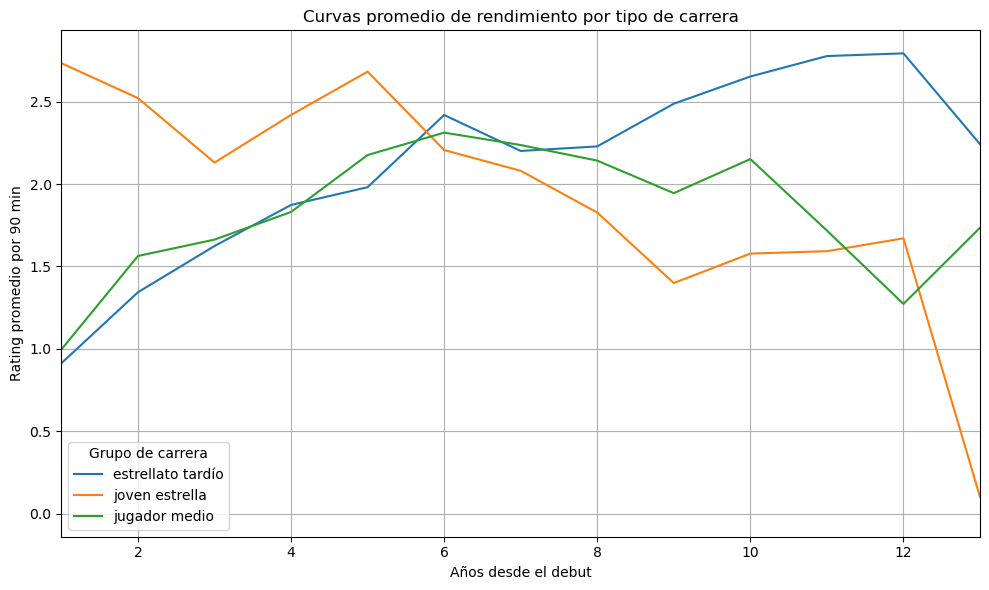

In [12]:
# ----------------------------------------------
# 🎯 Etapa 5: Curvas promedio de rendimiento por tipo de carrera
# ----------------------------------------------
# Objetivo:
# - Construir la trayectoria por año desde el debut para cada jugador
# - Agrupar por tipo de carrera (`peak_group`)
# - Calcular promedios anuales de rendimiento (rating_per_90)
# - Generar visualización agregada por grupo
# ----------------------------------------------

import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
debut_dates = df[df['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df['debut_year'] = df['Player_ID'].map(debut_dates).dt.year
df['year_since_debut'] = df['Date'].dt.year - df['debut_year'] + 1
df['age'] = (df['Date'] - df['Birth_date']).dt.days / 365.25
df['age_year_1'] = df.groupby('Player_ID')['age'].transform('first')

# ----------------------------------------------
# 🧱 Construcción de career_df: rendimiento año a año desde debut
# ----------------------------------------------

career_df = df.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age_year_1': 'first'
}).reset_index()

# Filtrar trayectorias con al menos 300 minutos jugados en ese año
# career_df = career_df[career_df['Minutes'] >= 300]

# ----------------------------------------------
# 🔁 Añadir grupo de carrera (peak_group)
# ----------------------------------------------
peak_groups = df_season[['Player_ID', 'peak_group']].drop_duplicates()
career_df = career_df.merge(peak_groups, on='Player_ID', how='left')

# ----------------------------------------------
# 📈 Curvas promedio por grupo y año relativo
# ----------------------------------------------
curves = (
    career_df.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
)

print("\n📊 Curvas promedio por grupo:")
print(curves.head(10))

# 🖼️ Visualización: rendimiento promedio por grupo (años 1 a 13)
# ----------------------------------------------
plt.figure(figsize=(10, 6))

for group in curves['peak_group'].unique():
    group_data = curves[(curves['peak_group'] == group) & (curves['year_since_debut'] <= 13)]
    plt.plot(
        group_data['year_since_debut'],
        group_data['rating_per_90'],
        label=group
    )

plt.title("Curvas promedio de rendimiento por tipo de carrera")
plt.xlabel("Años desde el debut")
plt.ylabel("Rating promedio por 90 min")
plt.grid(True)
plt.legend(title="Grupo de carrera")
plt.xlim(1, 13)
plt.tight_layout()
plt.show()

# ----------------------------------------------
# ✅ Resultado:
# - `career_df` contiene la evolución real por jugador desde su debut
# - `curves` contiene la media por grupo y año (lista para usar como referencia)
# ----------------------------------------------


In [13]:
# ----------------------------------------------
# 🎯 Etapa 6: Construcción del dataset de modelado
# ----------------------------------------------
# Objetivo:
# - Tomar solo los primeros 3 años desde el debut
# - Pivotar los datos en formato ancho (wide) para modelo tabular
# - Calcular variables derivadas y añadir el grupo objetivo (peak_group)
# ----------------------------------------------

# 1. Seleccionamos los primeros 3 años desde el debut
early_years = career_df[career_df['year_since_debut'] <= 3]

# 2. Pivotamos para transformar años en columnas
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age_year_1')  # edad constante por jugador
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')

# 3. Renombramos las columnas para consistencia
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 4. Concatenamos todas las características base
df_model = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# Suma de minutos como feature adicional
df_model['minutes_sum'] = df_model[[c for c in df_model.columns if c.startswith('minutes_year_')]].sum(axis=1)


# Factor de fiabilidad por año (minutos entre 600, truncado entre 0 y 1)
for i in [1, 2, 3]:
    min_col = f'minutes_year_{i}'
    if min_col in df_model.columns:
        df_model[f'minutes_weight_{i}'] = df_model[min_col].clip(0, 600) / 600


# ----------------------------------------------
# 5. Variables derivadas (solo si los años existen)
# ----------------------------------------------
if 'rating_year_2' in df_model and 'rating_year_1' in df_model:
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if 'rating_year_3' in df_model and 'rating_year_2' in df_model:
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# Promedio de rating y suma de minutos totales
df_model['avg_rating'] = df_model[[c for c in df_model.columns if c.startswith('rating_year_')]].mean(axis=1)
df_model['sum_minutes'] = df_model[[c for c in df_model.columns if c.startswith('minutes_year_')]].sum(axis=1)

# Tendencias largas si tenemos años 1 y 3
if 'rating_year_3' in df_model and 'rating_year_1' in df_model:
    df_model['rating_trend'] = df_model['rating_year_3'] - df_model['rating_year_1']
if 'minutes_year_3' in df_model and 'minutes_year_1' in df_model:
    df_model['minutes_trend'] = df_model['minutes_year_3'] - df_model['minutes_year_1']

# ----------------------------------------------
# 6. Añadir variable objetivo (peak_group)
# ----------------------------------------------
df_model = df_model.merge(
    df_season[['Player_ID', 'peak_group']].drop_duplicates(),
    on='Player_ID',
    how='inner'
)

# ----------------------------------------------
# 7. Filtro: jugadores con al menos 1 año con rating
# ----------------------------------------------
rating_cols = [c for c in df_model.columns if c.startswith('rating_year_')]
valid_seasons = df_model[rating_cols].notna().sum(axis=1)
df_model = df_model[valid_seasons >= 1].copy()

# ----------------------------------------------
# 8. Rellenamos nulos restantes (seguro para modelos tipo RandomForest, XGBoost)
# ----------------------------------------------
df_model.fillna(0, inplace=True)

# ----------------------------------------------
# 9. Verificación final
# ----------------------------------------------
print("\n📦 Dataset final para modelado:")
print(df_model.head())

print("\n🎯 Distribución del target (peak_group):")
print(df_model['peak_group'].value_counts())




📦 Dataset final para modelado:
  Player_ID  rating_year_0  rating_year_1  rating_year_2  rating_year_3  \
0  0061247c            0.0      -0.424862      -0.441176       0.000000   
1  0085841a            0.0       0.799376       3.894406       0.564313   
2  00f0e85a            0.0       5.000000       0.000000       0.000000   
3  0118dd71            0.0       0.000000      -0.333333      -0.071429   
4  01699656            0.0       1.000000       0.425682       0.730954   

   age_year_0  age_year_1  age_year_2  age_year_3  minutes_year_0  ...  \
0         0.0   23.496235   23.496235    0.000000             0.0  ...   
1         0.0   21.048597   21.048597   21.048597             0.0  ...   
2         0.0   31.978097    0.000000    0.000000             0.0  ...   
3         0.0   24.049281   24.049281   24.049281             0.0  ...   
4         0.0   23.811088   23.811088   23.811088             0.0  ...   

   minutes_weight_1  minutes_weight_2  minutes_weight_3  growth_2_1  \
0

In [14]:
# ----------------------------------------------
# 🎯 Etapa 7: División del dataset y codificación del target
# ----------------------------------------------
# Objetivo:
# - Codificar la variable objetivo (peak_group)
# - Dividir los datos entre entrenamiento y test sin mezclar jugadores
# - Asegurar que la división es estratificada por clase
# ----------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Reestablecer índice por orden
df_model = df_model.reset_index(drop=True)

# 2. Codificar la variable objetivo (peak_group → entero)
le = LabelEncoder()
df_model['peak_group_encoded'] = le.fit_transform(df_model['peak_group'])

# 3. Obtener lista única de jugadores y su clase (para stratify)
player_targets = df_model.drop_duplicates('Player_ID')[['Player_ID', 'peak_group_encoded']]

# 4. División train/test por jugador
train_ids, test_ids = train_test_split(
    player_targets['Player_ID'],
    test_size=0.2,
    stratify=player_targets['peak_group_encoded'],
    random_state=42
)

# 5. Creamos subconjuntos finales (sin fuga de jugadores entre train y test)
train_df = df_model[df_model['Player_ID'].isin(train_ids)].copy()
test_df = df_model[df_model['Player_ID'].isin(test_ids)].copy()

# 6. Separamos X / y
X_train = train_df.drop(columns=['peak_group', 'peak_group_encoded', 'Player_ID'])
y_train = train_df['peak_group_encoded']

X_test = test_df.drop(columns=['peak_group', 'peak_group_encoded', 'Player_ID'])
y_test = test_df['peak_group_encoded']

# ----------------------------------------------
# 🔍 Verificación de tamaño y clases
# ----------------------------------------------
print(f"✅ Train: {X_train.shape[0]} muestras, {train_df['Player_ID'].nunique()} jugadores únicos")
print(f"✅ Test:  {X_test.shape[0]} muestras, {test_df['Player_ID'].nunique()} jugadores únicos")
print(f"🎯 Clases codificadas: {list(le.classes_)}")



✅ Train: 1080 muestras, 1080 jugadores únicos
✅ Test:  270 muestras, 270 jugadores únicos
🎯 Clases codificadas: ['estrellato tardío', 'joven estrella', 'jugador medio']


In [31]:
print("Distribución del target (peak_group):")
print(df_model['peak_group'].value_counts())


Distribución del target (peak_group):
peak_group
jugador medio        513
estrellato tardío    478
joven estrella       359
Name: count, dtype: int64


In [15]:
# ----------------------------------------------
# 🎯 Etapa 8: Entrenamiento y evaluación de modelos multiclase
# ----------------------------------------------
# Objetivo:
# - Comparar RandomForest, XGBoost y LightGBM con parámetros similares
# - Evaluar rendimiento con métricas robustas
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

# ----------------------------------------------
# 1. Definición de modelos y parámetros
# ----------------------------------------------
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        num_class=3,
        learning_rate=0.05,
        max_depth=6,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=3,
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# ----------------------------------------------
# 2. Entrenamiento y evaluación de cada modelo
# ----------------------------------------------
for name, model in models.items():
    print(f"\n🔧 Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas principales
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n📊 Resultados para {name}:")
    print(f"✅ Accuracy: {acc:.3f}")
    print(f"🧠 Kappa Score: {kappa:.3f}")
    print(f"📈 MCC: {mcc:.3f}")

    # Reporte por clase
    print("\n📄 Clasification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Matriz de confusión
    print("📉 Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))




🔧 Entrenando modelo: RandomForest

📊 Resultados para RandomForest:
✅ Accuracy: 0.648
🧠 Kappa Score: 0.463
📈 MCC: 0.466

📄 Clasification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.73      0.63      0.68        95
   joven estrella       0.70      0.62      0.66        72
    jugador medio       0.56      0.68      0.62       103

         accuracy                           0.65       270
        macro avg       0.67      0.65      0.65       270
     weighted avg       0.66      0.65      0.65       270

📉 Matriz de Confusión:
[[60  5 30]
 [ 3 45 24]
 [19 14 70]]

🔧 Entrenando modelo: XGBoost


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\xgboost\training.py:183: UserWarning: [19:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Resultados para XGBoost:
✅ Accuracy: 0.622
🧠 Kappa Score: 0.431
📈 MCC: 0.432

📄 Clasification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.68      0.63      0.66        95
   joven estrella       0.63      0.74      0.68        72
    jugador medio       0.56      0.53      0.55       103

         accuracy                           0.62       270
        macro avg       0.62      0.63      0.63       270
     weighted avg       0.62      0.62      0.62       270

📉 Matriz de Confusión:
[[60  5 30]
 [ 6 53 13]
 [22 26 55]]

🔧 Entrenando modelo: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4320
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 19
[LightGBM] [Info] Start training from score -1.036681
[LightGBM] [Info] Start training from score -1

In [16]:
# ----------------------------------------------
# 🎯 Etapa 9: Limpieza de outliers extremos en ratings
# ----------------------------------------------
# Objetivo:
# - Asegurar que ningún valor de rating por 90 min sea irreal (ej: >10)
# - Recalcular las variables derivadas después de aplicar los límites
# ----------------------------------------------

# 1. Identificamos las columnas de rating (por año + promedio)
rating_cols = [col for col in df_model.columns if col.startswith('rating_year_') or col == 'avg_rating']

# 2. Aplicamos límites razonables (ej: 0 a 10 como escala humana)
for col in rating_cols:
    df_model[col] = df_model[col].clip(lower=0, upper=10)

# 3. Recalculamos variables derivadas (porque el clipping puede haberlas cambiado)
if 'rating_year_2' in df_model and 'rating_year_1' in df_model:
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if 'rating_year_3' in df_model and 'rating_year_2' in df_model:
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# 4. Verificación de rangos finales
print("\n📊 Verificación de estadísticas tras limpieza:")
print(df_model[rating_cols].describe())



📊 Verificación de estadísticas tras limpieza:
       rating_year_0  rating_year_1  rating_year_2  rating_year_3   avg_rating
count         1350.0    1350.000000    1350.000000    1350.000000  1350.000000
mean             0.0       1.379609       1.264157       1.167732     1.530777
std              0.0       2.082236       1.835749       1.623572     1.762237
min              0.0       0.000000       0.000000       0.000000     0.000000
25%              0.0       0.000000       0.000000       0.000000     0.099139
50%              0.0       0.470637       0.414145       0.449883     1.095432
75%              0.0       2.005759       2.076764       1.920144     2.184358
max              0.0      10.000000      10.000000      10.000000    10.000000


In [17]:
# ----------------------------------------------
# 🎯 Etapa 10: Optimización de RandomForest con RandomizedSearchCV
# ----------------------------------------------
# Objetivo:
# - Buscar la mejor combinación de hiperparámetros para RandomForest
# - Evaluar el rendimiento tras el tuning
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)
import numpy as np

# 1. Espacio de búsqueda (hiperparámetros relevantes)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 2. Inicializamos el modelo base
rf = RandomForestClassifier(random_state=42)

# 3. RandomizedSearchCV (con validación cruzada y paralelización)
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,               # número de combinaciones a probar
    cv=3,                     # validación cruzada
    verbose=1,
    n_jobs=-1,                # usa todos los núcleos disponibles
    random_state=42
)

# 4. Entrenamiento
print("🔍 Buscando mejores hiperparámetros para RandomForest...")
rf_search.fit(X_train, y_train)

# 5. Evaluación con mejor modelo encontrado
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n✅ Mejor combinación de hiperparámetros:")
print(rf_search.best_params_)

print("\n📊 Resultados tras tuning:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC: {matthews_corrcoef(y_test, y_pred):.3f}")



🔍 Buscando mejores hiperparámetros para RandomForest...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
96 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constra


✅ Mejor combinación de hiperparámetros:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

📊 Resultados tras tuning:
✅ Accuracy: 0.659

📄 Classification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.74      0.62      0.67        95
   joven estrella       0.67      0.72      0.69        72
    jugador medio       0.60      0.65      0.62       103

         accuracy                           0.66       270
        macro avg       0.67      0.66      0.66       270
     weighted avg       0.67      0.66      0.66       270

📉 Matriz de Confusión:
[[59  8 28]
 [ 3 52 17]
 [18 18 67]]
🧠 Kappa Score: 0.484
📈 MCC: 0.486


In [18]:
# ----------------------------------------------
# 🎯 Etapa 11: Optimización de RandomForest con GridSearchCV
# ----------------------------------------------
# Objetivo:
# - Probar todas las combinaciones posibles de un grid pequeño y sensato
# - Seleccionar el modelo con mejor rendimiento medio en validación cruzada
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)

# 1. Definimos un grid pequeño pero razonable de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [6, 10],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# 2. Inicializamos el modelo base
rf = RandomForestClassifier(random_state=42)

# 3. GridSearchCV con validación cruzada estratificada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 4. Entrenamiento del grid
print("🔍 Ejecutando GridSearchCV...")
grid_search.fit(X_train, y_train)

# 5. Evaluación con el mejor estimador encontrado
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# 6. Resultados
print("\n✅ Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

print("\n📊 Resultados del modelo optimizado:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC: {matthews_corrcoef(y_test, y_pred):.3f}")


🔍 Ejecutando GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Mejor combinación de hiperparámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 400}

📊 Resultados del modelo optimizado:
✅ Accuracy: 0.670

📄 Classification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.78      0.66      0.72        95
   joven estrella       0.67      0.71      0.69        72
    jugador medio       0.59      0.65      0.62       103

         accuracy                           0.67       270
        macro avg       0.68      0.67      0.68       270
     weighted avg       0.68      0.67      0.67       270

📉 Matriz de Confusión:
[[63  4 28]
 [ 3 51 18]
 [15 21 67]]
🧠 Kappa Score: 0.500
📈 MCC: 0.502


# Sugerencias Julio

* Meter medias e intervalos de confianza en gráfica

* Usar los dos modelos

* Tener todo en una página de streamlit

* Feedback

* Formulario de google no más de 10 preguntas (opciones y caja de comentarios)

* ¿Cómo vender? Idea de negocio, corto, medio y largo plazo

* Vídeo presentación para ir enseñando a gente de Evolve y empresas.

C:\Users\juanm\AppData\Local\Temp\ipykernel_39224\751709336.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


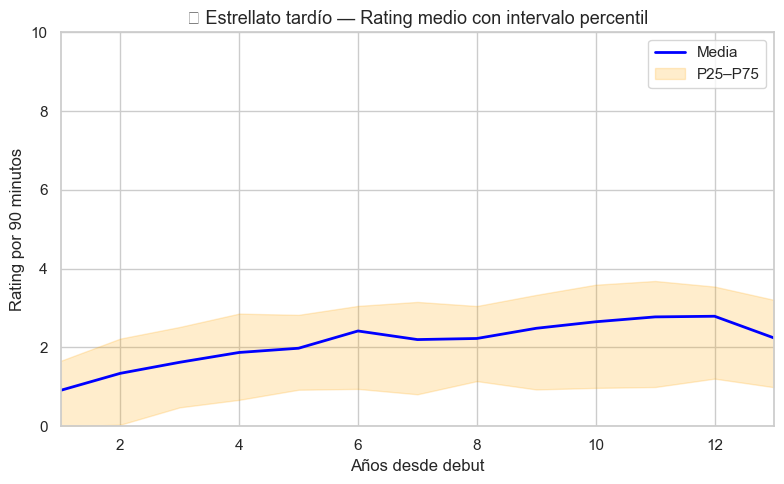

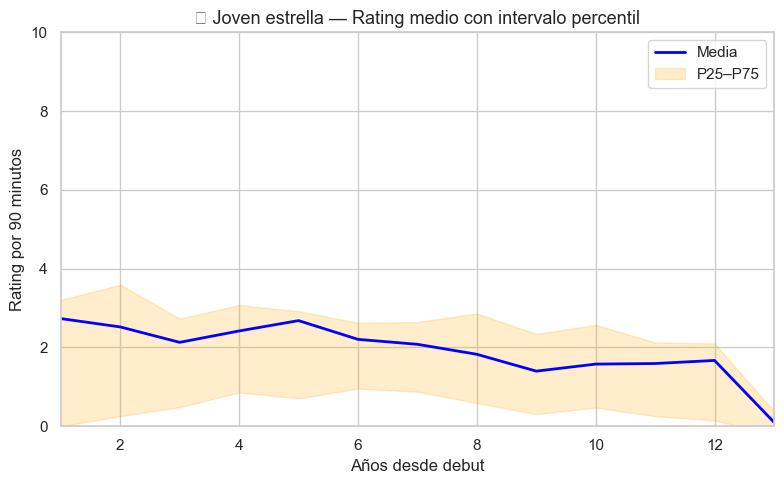

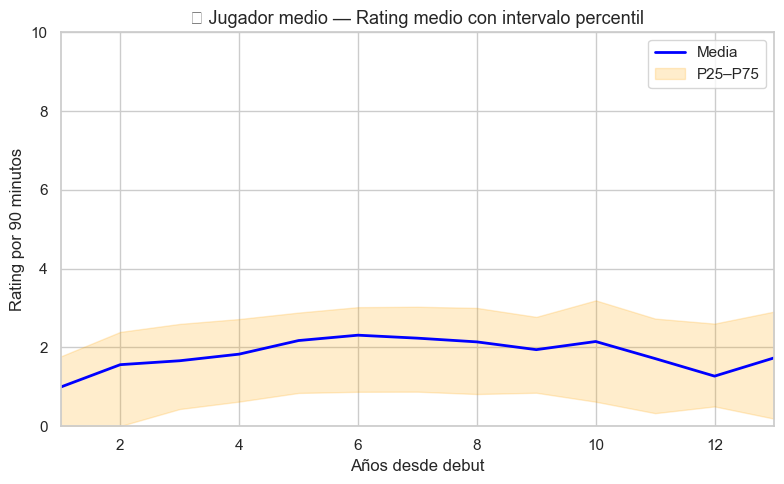

In [19]:
# ----------------------------------------------
# 🎯 Análisis visual de curvas con bandas de variabilidad (P25–P75)
# ----------------------------------------------
# Objetivo:
# - Visualizar el rendimiento medio por grupo (rating_per_90)
# - Añadir bandas de percentiles (25 y 75) como representación de dispersión
# ----------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Agrupamos por grupo y año relativo desde debut
group_stats = career_df.groupby(['peak_group', 'year_since_debut'])['rating_per_90'].agg(
    mean='mean',
    std='std',
    count='count',
    p25=lambda x: np.percentile(x, 25),
    p75=lambda x: np.percentile(x, 75)
).reset_index()

# 2. Limitamos a los primeros 13 años desde debut
group_stats = group_stats[group_stats['year_since_debut'] <= 13]

# ----------------------------------------------
# 3. Gráfica por grupo con bandas percentiles
# ----------------------------------------------
sns.set(style="whitegrid")
unique_groups = group_stats['peak_group'].unique()

for group in unique_groups:
    subset = group_stats[group_stats['peak_group'] == group]

    plt.figure(figsize=(8, 5))

    # Línea media
    plt.plot(
        subset['year_since_debut'], subset['mean'],
        label='Media', color='blue', linewidth=2
    )

    # Banda de percentiles (P25–P75)
    plt.fill_between(
        subset['year_since_debut'],
        subset['p25'],
        subset['p75'],
        color='orange',
        alpha=0.2,
        label='P25–P75'
    )

    # Configuración del gráfico
    plt.title(f"📊 {group.capitalize()} — Rating medio con intervalo percentil", fontsize=13)
    plt.xlabel("Años desde debut")
    plt.ylabel("Rating por 90 minutos")
    plt.xlim(1, 13)
    plt.ylim(0, 10)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
print("🔍 df_season shape:", df_season.shape)
print("🔍 df_season columnas:", df_season.columns.tolist())
print("🔍 Valores únicos en peak_group:", df_season['peak_group'].unique())
print("🔍 Muestra de df_season:")
display(df_season.head())


🔍 df_season shape: (9522, 12)
🔍 df_season columnas: ['Player_ID', 'Calendar_year', 'Minutes', 'Goals', 'Assists', 'rating_per_90', 'Age', 'peak_year', 'peak_rating', 'age_at_peak', 'peak_group', 'year_since_debut']
🔍 Valores únicos en peak_group: ['joven estrella' 'estrellato tardío' 'jugador medio']
🔍 Muestra de df_season:


,Player_ID,Calendar_year,Minutes,Goals,Assists,rating_per_90,Age,peak_year,peak_rating,age_at_peak,peak_group,year_since_debut
0,0061247c,1999,503.0,0.0,0.0,-0.424862,22.092402,1999,-0.424862,22.092402,joven estrella,NaN
1,0061247c,2000,146.0,0.0,0.0,-0.441176,23.620123,1999,-0.424862,22.092402,joven estrella,NaN
2,0085841a,2022,2441.0,1.0,7.0,0.799376,20.473967,2023,3.894406,21.341351,joven estrella,NaN
3,0085841a,2023,1066.0,2.0,1.0,3.894406,21.341351,2023,3.894406,21.341351,joven estrella,NaN
4,0085841a,2024,1717.0,1.0,3.0,0.564313,22.531436,2023,3.894406,21.341351,joven estrella,NaN


In [32]:
# ----------------------------------------------
# 🎯 Etapa final: Guardado de modelo y recursos
# ----------------------------------------------

import joblib
from pathlib import Path

# 1. Ruta donde se guardan los objetos del modelo
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# 2. Aseguramos cuál es el mejor modelo (elige manualmente cuál usar)
final_model = grid_search.best_estimator_  # puedes cambiar esto a model, rf_search.best_estimator_, etc.

# 3. Guardamos el modelo entrenado
joblib.dump(final_model, 'model/futpeak_model_multi.joblib')

# 4. Guardamos el label encoder
joblib.dump(le, model_dir / "label_encoder.joblib")

# 5. Guardamos las columnas utilizadas para entrenar el modelo
joblib.dump(X_train.columns.tolist(), model_dir / "model_features.joblib")

# 6. Generamos las curvas promedio por grupo (de nuevo, con year_since_debut)
debut_years = df_season.groupby('Player_ID')['Calendar_year'].min().to_dict()
df_season = df_season.copy()
df_season['year_since_debut'] = df_season['Player_ID'].map(debut_years)
df_season['year_since_debut'] = df_season['Calendar_year'] - df_season['year_since_debut'] + 1

# ⚠️ Validar que no haya NaNs
df_season = df_season[df_season['year_since_debut'].notna()]

# Crear curvas
df_curves = (
    df_season.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
    .rename(columns={'rating_per_90': 'rating_avg'})
)

# Guardar
joblib.dump(df_curves, 'model/curvas_promedio.joblib')
print("✅ Curvas promedio guardadas correctamente.")


print("✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.")


✅ Curvas promedio guardadas correctamente.
✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.


In [33]:
import os
print("📁 ¿Existe el archivo después de guardar?", os.path.exists("model/curvas_promedio.joblib"))


📁 ¿Existe el archivo después de guardar? True


In [35]:
print(df_curves.shape)
df_curves


(59, 3)


,peak_group,year_since_debut,rating_avg
0,estrellato tardío,1,0.912871
1,estrellato tardío,2,1.343368
2,estrellato tardío,3,1.623827
3,estrellato tardío,4,1.873032
4,estrellato tardío,5,1.980625
5,estrellato tardío,6,2.418521
6,estrellato tardío,7,2.200525
7,estrellato tardío,8,2.228165
8,estrellato tardío,9,2.487056
9,estrellato tardío,10,2.652116


In [21]:
# Cuántos jugadores aportan datos a cada year_since_debut
players_per_year = career_df.groupby('year_since_debut')['Player_ID'].nunique().reset_index()
players_per_year.columns = ['Año desde debut', 'Nº jugadores']
print(players_per_year)



    Año desde debut  Nº jugadores
0                 0             1
1                 1          1350
2                 2           989
3                 3           889
4                 4           850
5                 5           844
6                 6           790
7                 7           799
8                 8           776
9                 9           761
10               10           653
11               11           407
12               12           181
13               13            75
14               14            55
15               15            44
16               16            26
17               17            15
18               18             8
19               19             4
20               20             2
21               21             1
22               22             1
23               25             1


In [22]:
minutes_by_year = career_df.groupby('year_since_debut')['Minutes'].mean().reset_index()
print(minutes_by_year.head(20))


    year_since_debut      Minutes
0                  0     0.000000
1                  1   583.860000
2                  2  1070.129424
3                  3  1327.489314
4                  4  1438.341176
5                  5  1499.168246
6                  6  1577.226582
7                  7  1652.817272
8                  8  1704.724227
9                  9  1540.982917
10                10  1255.194487
11                11  1181.235872
12                12  1146.558011
13                13  1299.320000
14                14  1338.890909
15                15  1339.204545
16                16  1222.230769
17                17  1529.400000
18                18  1620.875000
19                19  1616.000000


In [23]:
# Verificar cálculo del año de debut
df_tmp = df.copy()
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
df_tmp['Natural_year'] = df_tmp['Date'].dt.year

# Agregamos debut por jugador
debut_by_player = df_tmp[df_tmp['Minutes'] > 0].groupby('Player_ID')['Natural_year'].min().reset_index()
debut_by_player.columns = ['Player_ID', 'Debut_year']

# Merge para revisar
df_debug = df_tmp.merge(debut_by_player, on='Player_ID')
df_debug['year_since_debut'] = df_debug['Natural_year'] - df_debug['Debut_year'] + 1

# Ahora buscamos valores extraños
print("\nJugadores con year_since_debut > 15:")
print(df_debug[df_debug['year_since_debut'] > 15][['Player_name', 'Natural_year', 'Debut_year', 'year_since_debut']].drop_duplicates())



Jugadores con year_since_debut > 15:
                Player_name  Natural_year  Debut_year  year_since_debut
142822       Lautaro Acosta          2025        2008                18
142848       Lautaro Acosta          2023        2008                16
142876       Lautaro Acosta          2024        2008                17
143011        Sergio Agüero          2021        2006                16
146374          Rubén Ayala          1998        1974                25
149991    Gonzalo Bergessio          2022        2007                16
155175      Pablo Calandria          2016        2001                16
155199      Pablo Calandria          2017        2001                17
155247      Pablo Calandria          2018        2001                18
160409  Andrés D'Alessandro          2020        2003                18
160439  Andrés D'Alessandro          2022        2003                20
160472  Andrés D'Alessandro          2019        2003                17
160560  Andrés D'Alessandr

In [24]:
# Jugadores con más edad al final de su carrera
print("\nJugadores con mayor edad en dataset:")
print(df.groupby("Player_ID")["Age"].max().sort_values(ascending=False).head(10))



Jugadores con mayor edad en dataset:
Player_ID
a20a0ee8    48.484600
29cf8777    43.318275
3b64f69d    41.856263
4cd813d5    41.848049
7768235d    41.544148
6a11048a    41.004791
96d19d5b    40.320329
8d8178ac    40.290212
12fe55da    39.920602
98131e80    39.329227
Name: Age, dtype: float64
